In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

In [2]:
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)
import random
random.seed(42)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, BatchNormalization, ReLU, AveragePooling1D, GlobalAveragePooling1D
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from google.colab import drive

!pip install keras-tuner -q
import keras_tuner
from keras_tuner import RandomSearch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# reading in csv
file_path = '/content/drive/My Drive/DS340/CHD_women.csv'
female_data = pd.read_csv(file_path, sep=",")

female_data.head(10)

,age,height,weight,sys_bp,dia_bp,cholesterol,gluc,smoke,alco,active,cardio
0,55.419,156,85.0,140,90,3,1,0,0,1,1
1,51.663,165,64.0,130,70,3,1,0,0,0,1
2,47.874,156,56.0,100,60,1,1,0,0,0,0
3,60.038,151,67.0,120,80,2,2,0,0,0,0
4,60.584,157,93.0,130,80,3,1,0,0,1,0
5,48.405,158,71.0,110,70,1,1,0,0,1,0
6,54.340,164,68.0,110,60,1,1,0,0,0,0
7,61.726,169,80.0,120,80,1,1,0,0,1,0
8,54.271,158,78.0,110,70,1,1,0,0,1,0
9,58.345,170,75.0,130,70,1,1,0,0,0,0


In [10]:
# Building CNN model based off of CNN structure from paper 2
# had to keep padding as "same" - does not match the paper
# also changed from softmax to sigmoid, as sigmoid is better for binary classification
def gender_model(hp):
    model = Sequential()

    # Layer 1: Dense layer w/ 64 neurons, batch normalization, ReLU activation and dropout
    # hyperparameter tuning ==> # of neurons
    model.add(Dense(units = hp.Int('Dense1_neuonrs', min_value = 32, max_value = 512, step = 32),
                    input_shape=(11, 1)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(hp.Float('Dense1_dropout', min_value = 0.1, max_value = 0.5, step = 0.05)))


    # Layer 2: Convolutional layer w/ 2 filters, kernel size of 4, no padding, 2 strides, Batch Normalization, ReLU and average pooling
    model.add(Conv1D(filters=2,
                     kernel_size= 4,
                     strides = 2,
                     padding = 'same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    #model.add(GlobalAveragePooling1D())


    # Layer 3: Convolutional layer w/ 4 filters, kernel size of 4, no padding, 2 strides, Batch Normalization, ReLU and average pooling
    model.add(Conv1D(filters=4,
                     kernel_size = 6,
                     strides = 2,
                     padding = 'same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    #model.add(GlobalAveragePooling1D())

    # had to add because of errors
    model.add(Flatten())

    # Layer 4: Dense layer with 512 neurons, Batch normalization, ReLU and dropout
    # Hyperparameter tuning ==> # of neurons
    model.add(Dense(units = hp.Int('Dense2_neurons', min_value = 32, max_value = 512, step = 32)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(hp.Float('Dense2_dropout', min_value = 0.1, max_value = 0.5, step = 0.05)))

    # Layer 5: Dense layer with 1 neuron
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [12]:
X_female = female_data.drop(columns=['cardio'])
y_female = female_data['cardio']

X_train_full, X_test, y_train_full, y_test = train_test_split(X_female, y_female, test_size=0.2, random_state=42, stratify=y_female)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full)

In [15]:
scaler_female = StandardScaler()
X_train = scaler_female.fit_transform(X_train)
X_val = scaler_female.transform(X_val)
X_test = scaler_female.transform(X_test)

In [16]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [19]:
# Instantiate Keras Tuner
tuner = RandomSearch(gender_model, objective='val_accuracy', max_trials=3, executions_per_trial=3,
                          directory='./DS340_CHD', project_name='tuner_female')


# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Get the best model and evaluate on the test set
best_model = tuner.get_best_models(num_models=1)[0]
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f'Test Loss (after tuning): {test_loss}, Test Accuracy (after tuning): {test_acc}')

Trial 3 Complete [00h 06m 12s]
val_accuracy: 0.7277200023333231

Best val_accuracy So Far: 0.7308882077534994
Total elapsed time: 00h 16m 16s
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7279 - loss: 0.5478
Test Loss (after tuning): 0.5449963212013245, Test Accuracy (after tuning): 0.7285330891609192


In [21]:
# Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model with the optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Summary of the best model
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 11, 448)             │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 11, 448)             │           1,792 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 11, 448)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 11, 448)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 6, 2)                │           3,586 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 6, 2)                │               8 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 6, 2)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 3, 4)                │              52 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 3, 4)                │              16 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 3, 4)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 160)                 │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 160)                 │             640 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,231 (36.06 KB)

 Trainable params: 8,003 (31.26 KB)

 Non-trainable params: 1,228 (4.80 KB)

In [22]:
!pip install scikeras
!pip install --upgrade scikit-learn
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import BaggingClassifier

def build_best_model():
    model = tuner.hypermodel.build(best_hps)
    return model

model = KerasClassifier(build_fn=build_best_model, epochs=20, batch_size=32, verbose=0)

# Now fit the bagging model
bagging_model = BaggingClassifier(estimator=model, n_estimators=10, random_state=42)
# Flatten X_train for the BaggingClassifier
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Fit bagging with flattened data
bagging_model.fit(X_train_flat, y_train)

BaggingClassifier(estimator=KerasClassifier(batch_size=32, build_fn=<function build_best_model at 0x7df4bd07d900>, epochs=20, verbose=0),
                  random_state=42)

In [23]:
# Step 8: Evaluate the model on the test set
from sklearn.metrics import accuracy_score

# Predict on the test data
y_pred = bagging_model.predict(X_test.reshape(X_test.shape[0], -1))  # Reshape X_test if needed

# Calculate accuracy
test_acc = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_acc}')

Test Accuracy: 0.7318872987477638


In [24]:
import shap
X_train_sample = shap.sample(X_train, 50)
X_test_sample = shap.sample(X_test, 50)

In [25]:
X_train_reshaped = X_train_sample.reshape(X_train_sample.shape[0], -1)
X_test_reshaped = X_test_sample.reshape(X_test_sample.shape[0], -1)

In [27]:
import joblib
import os

drive_path = '/content/drive/My Drive/DS340/'  # Replace with your folder name
explainer_file = os.path.join(drive_path, 'shap_explainer_females.pkl')


if os.path.exists(explainer_file):
  explainer = joblib.load(explainer_file)
else:
  # Create SHAP explainer
  explainer = shap.KernelExplainer(bagging_model.predict, X_train_reshaped,approximate = True)

  # Calculate SHAP values (this might take some time)
  shap_values = explainer.shap_values(X_test_reshaped)

  # saving explainer to google drive
  joblib.dump(explainer, explainer_file)

  0%|          | 0/50 [00:00<?, ?it/s]

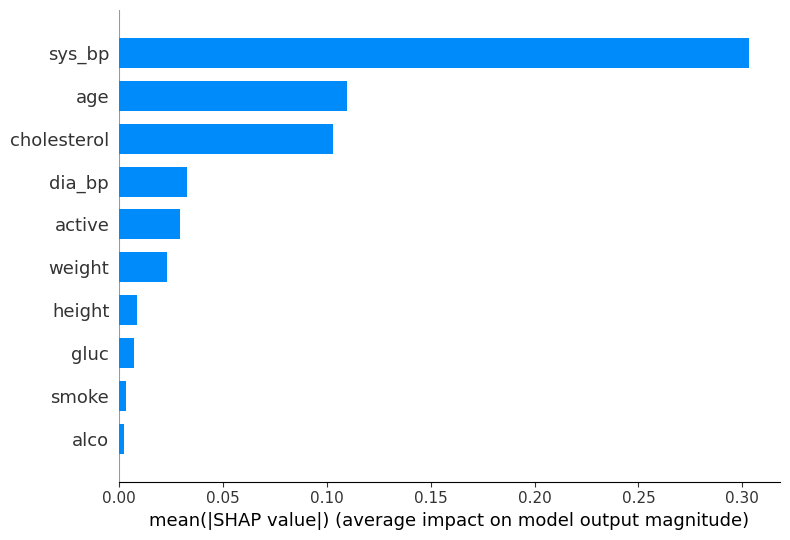

In [35]:
feature_names = ['age', 'height', 'weight', 'sys_bp', 'dia_bp', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
shap.summary_plot(shap_values, X_test_reshaped, feature_names=feature_names, plot_type='bar')

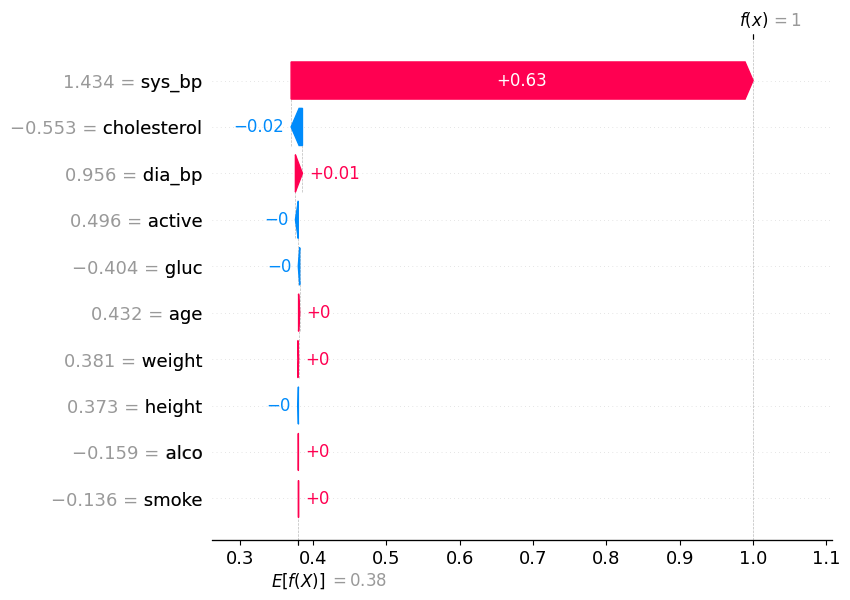

In [36]:
shap.waterfall_plot(shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=X_test_reshaped[0], feature_names=feature_names))

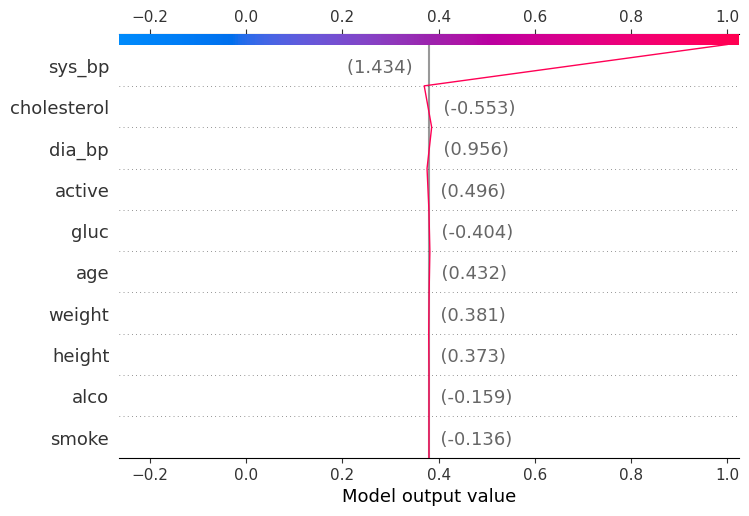

In [37]:
shap.decision_plot(explainer.expected_value, shap_values[0], X_test_reshaped, feature_names=feature_names)

In [38]:
!pip install lime
from lime.lime_tabular import LimeTabularExplainer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d2247ef40c141a80dfce137591316e37ad7fdf4f9ac223eb18618f2c2b446d1a
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [39]:
lime_explainer = LimeTabularExplainer(
    training_data=X_train_reshaped,  # Use training data for background
    feature_names= feature_names,  # Feature names
    class_names= ['No CHD', 'CHD'],
    mode='classification'  # Use 'regression' for regression tasks
)

In [40]:
# doing LIME for first 10 test instances
test_instance = X_test_reshaped[0]  # First test sample

# Generate explanation for the prediction
explanation = lime_explainer.explain_instance(
    data_row=test_instance,
    predict_fn=bagging_model.predict_proba  # Function to predict probabilities
)